In [1]:
# Import Required Libraries
from matplotlib import pyplot as plt
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

import seaborn as sn
import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

# Set Up Classification Models
- gnb = Gaussian Naive Bayes
- base_t = Default Decision tree
- per = Perceptron
- base_mlp = Default Multi-Layer Perceptron

In [2]:
# Import Models
import csv
gnb = GaussianNB()
base_t = tree.DecisionTreeClassifier()
per = Perceptron()
base_mlp = MLPClassifier()

# Data Imports
### Imports the data from data 1 and data 2

In [3]:
# Import Data
test_data_1 = np.genfromtxt('./data 1/test_no_label_1.csv', delimiter=',')
test_data_2 = np.genfromtxt('./data 2/test_no_label_2.csv', delimiter=',')

labeled_test_data_1 = np.genfromtxt('./data 1/test_with_label_1.csv', delimiter=',')
labeled_test_data_2 = np.genfromtxt('./data 2/test_with_label_2.csv', delimiter=',')

train_data_1 = np.genfromtxt('./data 1/train_1.csv', delimiter=',')
train_data_2 = np.genfromtxt('./data 2/train_2.csv', delimiter=',')

val_data_1 = np.genfromtxt('./data 1/val_1.csv', delimiter=',')
val_data_2 = np.genfromtxt('./data 2/val_2.csv', delimiter=',')

# Reference Dictionaries
### Sets up dictionaries to translate values to symbolic names ({0 : 'A', 1 : 'B', etc}

In [4]:
# Get Value Dictionaries
data_1 = {}
with open('data 1/info_1.csv', mode='r') as infile:
    reader = csv.reader(infile)
    next(reader, None) # Skip header
    with open('coors_new.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        for rows in reader:
            data_1[int(rows[0])] = rows[1]
data_2 = {}
with open('data 2/info_2.csv', mode='r') as infile:
    reader = csv.reader(infile)
    next(reader, None) # Skip header
    with open('coors_new.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        for rows in reader:
            data_2[int(rows[0])] = rows[1]

# Plotting Utility Method
### Reusable method to return a scatter plot of frequency distributions for a given data set
- takes a dataset as input, and the plot title
    - gets labels for dataset by extracting last column of each row: data_labels
    - generates a tuple (count, label) for each label found
    - reduces list of tuples to a set to get one of each label only
    - assigns labels to x axis on data_x and counts to y axis on data_y

In [5]:
# Distribution Plot Methods
def distribution(data, title, ref):
    data_labels = [ref[(row[-1])] for row in data]
    tuples = sorted(set([(label, data_labels.count(label)) for label in data_labels]))
    print(tuples)
    
    data_x = [x[0] for x in tuples]
    data_y = [y[1] for y in tuples]
    
    plt.scatter(data_x, data_y)
    plt.xlabel("Classes")
    plt.ylabel("Frequencies")
    plt.title(title)
    plt.show()

# Distributions for Data 1 and Data 2
- Training Set
- Labeled Test Set
- Validation Set

[('A', 52), ('B', 43), ('C', 52), ('D', 40), ('E', 38), ('F', 39), ('G', 52), ('H', 44), ('I', 52), ('J', 52), ('K', 52), ('L', 52), ('M', 52), ('N', 52), ('O', 52), ('P', 49), ('Q', 47), ('R', 52), ('S', 43), ('T', 39), ('U', 40), ('V', 39), ('W', 43), ('X', 38), ('Y', 39), ('Z', 44)]


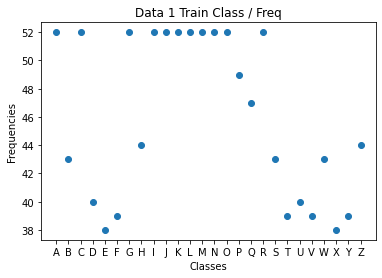

[('A', 4), ('B', 2), ('C', 4), ('D', 3), ('E', 2), ('F', 2), ('G', 4), ('H', 3), ('I', 3), ('J', 4), ('K', 3), ('L', 4), ('M', 3), ('N', 4), ('O', 3), ('P', 3), ('Q', 3), ('R', 4), ('S', 3), ('T', 2), ('U', 3), ('V', 3), ('W', 3), ('X', 2), ('Y', 3), ('Z', 3)]


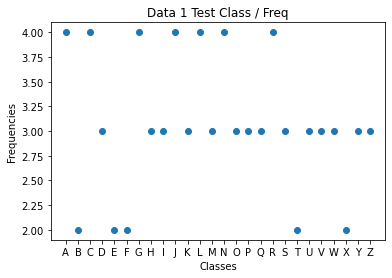

[('A', 10), ('B', 9), ('C', 10), ('D', 8), ('E', 8), ('F', 8), ('G', 10), ('H', 9), ('I', 10), ('J', 10), ('K', 10), ('L', 10), ('M', 10), ('N', 10), ('O', 10), ('P', 10), ('Q', 10), ('R', 10), ('S', 9), ('T', 8), ('U', 8), ('V', 8), ('W', 9), ('X', 8), ('Y', 8), ('Z', 9)]


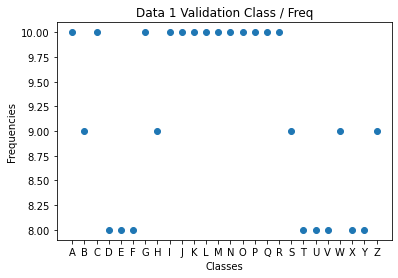

In [6]:
# Distributions for Data 1
distribution(train_data_1, "Data 1 Train Class / Freq", data_1)
distribution(labeled_test_data_1, "Data 1 Test Class / Freq", data_1)
distribution(val_data_1, "Data 1 Validation Class / Freq", data_1)

[('alpha', 1875), ('beta', 225), ('delta', 825), ('gamma', 750), ('lambda', 225), ('mu', 750), ('omega', 225), ('pi', 825), ('sigma', 225), ('xi', 1875)]


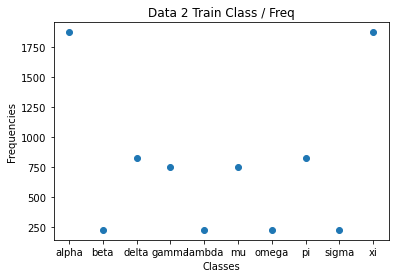

[('alpha', 125), ('beta', 15), ('delta', 55), ('gamma', 50), ('lambda', 15), ('mu', 50), ('omega', 15), ('pi', 55), ('sigma', 15), ('xi', 125)]


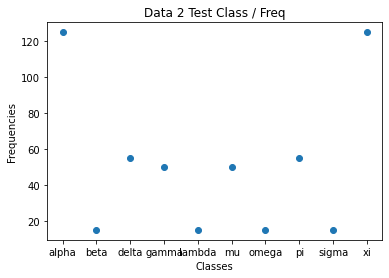

[('alpha', 375), ('beta', 45), ('delta', 165), ('gamma', 150), ('lambda', 45), ('mu', 150), ('omega', 45), ('pi', 165), ('sigma', 45), ('xi', 375)]


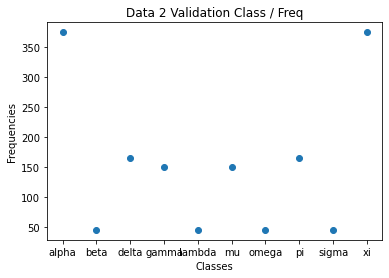

In [7]:
# Distributions for Data 2
distribution(train_data_2, "Data 2 Train Class / Freq", data_2)
distribution(labeled_test_data_2, "Data 2 Test Class / Freq", data_2)
distribution(val_data_2, "Data 2 Validation Class / Freq", data_2)

# General Model Testing/Training Procedure (Supervised)
### Training
- Split training data into features vectors (x_train) and label vector (y_train)
- Fit data to the model

### Testing
- Split test data into features vector (x_test) and label vector (y_test)
- Get label classification vector from trained model (prediction)

### Output
- Print actual labels
- Print model label predictions
- Print model label predictions to csv file
- Print prediction misses (comparision between prediction and y_test)
- Compare model label classification vector (prediction) to label vector (y_test)
    

[(0, 'F'), (1, 'N'), (2, 'H'), (3, 'C'), (4, 'S'), (5, 'R'), (6, 'Z'), (7, 'X'), (8, 'W'), (9, 'U'), (10, 'G'), (11, 'J'), (12, 'L'), (13, 'T'), (14, 'B'), (15, 'F'), (16, 'B'), (17, 'I'), (18, 'C'), (19, 'M'), (20, 'Q'), (21, 'A'), (22, 'Z'), (23, 'R'), (24, 'Q'), (25, 'B'), (26, 'W'), (27, 'I'), (28, 'V'), (29, 'M'), (30, 'B'), (31, 'M'), (32, 'K'), (33, 'Q'), (34, 'K'), (35, 'R'), (36, 'Q'), (37, 'B'), (38, 'P'), (39, 'M'), (40, 'Q'), (41, 'L'), (42, 'N'), (43, 'B'), (44, 'N'), (45, 'R'), (46, 'M'), (47, 'O'), (48, 'Y'), (49, 'A'), (50, 'A'), (51, 'D'), (52, 'W'), (53, 'U'), (54, 'D'), (55, 'O'), (56, 'Z'), (57, 'J'), (58, 'P'), (59, 'O'), (60, 'N'), (61, 'C'), (62, 'L'), (63, 'M'), (64, 'R'), (65, 'G'), (66, 'G'), (67, 'U'), (68, 'N'), (69, 'D'), (70, 'Y'), (71, 'W'), (72, 'V'), (73, 'I'), (74, 'V'), (75, 'S'), (76, 'A'), (77, 'R'), (78, 'M'), (79, 'T')]
[(0, 'E'), (1, 'N'), (2, 'H'), (3, 'C'), (4, 'S'), (5, 'R'), (6, 'L'), (7, 'X'), (8, 'W'), (9, 'U'), (10, 'C'), (11, 'J'), (12, '

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


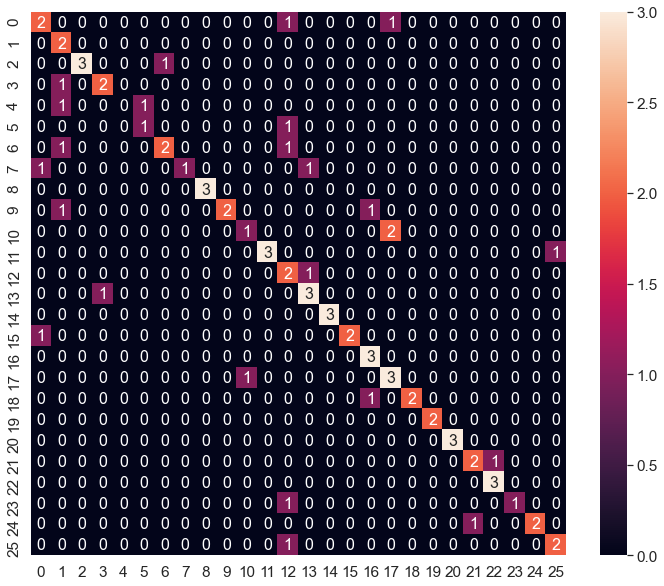


Classification report:
              precision    recall  f1-score   support

         0.0       0.50      0.50      0.50         4
         1.0       0.33      1.00      0.50         2
         2.0       1.00      0.75      0.86         4
         3.0       0.67      0.67      0.67         3
         4.0       0.00      0.00      0.00         2
         5.0       0.50      0.50      0.50         2
         6.0       0.67      0.50      0.57         4
         7.0       1.00      0.33      0.50         3
         8.0       1.00      1.00      1.00         3
         9.0       1.00      0.50      0.67         4
        10.0       0.50      0.33      0.40         3
        11.0       1.00      0.75      0.86         4
        12.0       0.29      0.67      0.40         3
        13.0       0.60      0.75      0.67         4
        14.0       1.00      1.00      1.00         3
        15.0       1.00      0.67      0.80         3
        16.0       0.60      1.00      0.75         3
   

In [8]:
# GNB-DS1
x_train = train_data_1[ :, :-1]
y_train = train_data_1[ :, -1]

gnb.fit(x_train, y_train)

x_test = labeled_test_data_1[ :, :-1]
y_test = labeled_test_data_1[ :, -1]

prediction = gnb.predict(x_test)
print([(entry, data_1[prediction[entry]]) for entry in range(prediction.size)])
print([(entry, data_1[y_test[entry]]) for entry in range(y_test.size)])
print((y_test != prediction).sum())


# write classification report
clsf_report = pd.DataFrame(classification_report(y_test, prediction, output_dict=True)).transpose()
clsf_report.to_csv('GNB-DS1.csv', index= True)

# write the predictions
with open('GNB-DS1.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for entry in range(prediction.size):
        writer.writerow([entry, int(prediction[entry])])
        
# get confusion matrix
labels = list(data_1.keys())
array = confusion_matrix(y_test, prediction, labels)
# append confusion matrix
with open("GNB-DS1.csv", "a") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(array)
    

#Plot confusion matrix: evaluates the quality of the output of the classifier
print("\n" + "Confusion matrix:")
df_cm = pd.DataFrame(array, range(26), range(26))
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
           
# show precision, recall, f1-score, etc
print("\n" + "Classification report:")
report = classification_report(y_test, prediction)
print(report)
        


[(0, 'xi'), (1, 'sigma'), (2, 'pi'), (3, 'delta'), (4, 'xi'), (5, 'sigma'), (6, 'alpha'), (7, 'sigma'), (8, 'lambda'), (9, 'xi'), (10, 'pi'), (11, 'alpha'), (12, 'sigma'), (13, 'xi'), (14, 'beta'), (15, 'sigma'), (16, 'xi'), (17, 'xi'), (18, 'omega'), (19, 'alpha'), (20, 'lambda'), (21, 'alpha'), (22, 'beta'), (23, 'omega'), (24, 'xi'), (25, 'beta'), (26, 'alpha'), (27, 'alpha'), (28, 'beta'), (29, 'beta'), (30, 'xi'), (31, 'beta'), (32, 'beta'), (33, 'xi'), (34, 'beta'), (35, 'alpha'), (36, 'lambda'), (37, 'xi'), (38, 'alpha'), (39, 'alpha'), (40, 'sigma'), (41, 'omega'), (42, 'gamma'), (43, 'delta'), (44, 'xi'), (45, 'xi'), (46, 'alpha'), (47, 'sigma'), (48, 'lambda'), (49, 'alpha'), (50, 'pi'), (51, 'gamma'), (52, 'delta'), (53, 'xi'), (54, 'pi'), (55, 'pi'), (56, 'mu'), (57, 'delta'), (58, 'lambda'), (59, 'alpha'), (60, 'alpha'), (61, 'lambda'), (62, 'sigma'), (63, 'pi'), (64, 'lambda'), (65, 'alpha'), (66, 'alpha'), (67, 'xi'), (68, 'pi'), (69, 'pi'), (70, 'sigma'), (71, 'pi'), (7

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


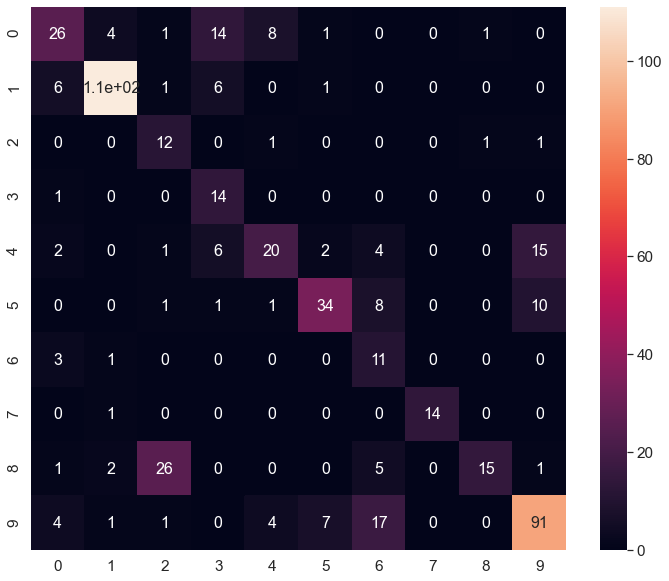


Classification report:
              precision    recall  f1-score   support

         0.0       0.60      0.47      0.53        55
         1.0       0.93      0.89      0.91       125
         2.0       0.28      0.80      0.41        15
         3.0       0.34      0.93      0.50        15
         4.0       0.59      0.40      0.48        50
         5.0       0.76      0.62      0.68        55
         6.0       0.24      0.73      0.37        15
         7.0       1.00      0.93      0.97        15
         8.0       0.88      0.30      0.45        50
         9.0       0.77      0.73      0.75       125

    accuracy                           0.67       520
   macro avg       0.64      0.68      0.60       520
weighted avg       0.75      0.67      0.68       520



In [9]:
# GNB-DS2
x_train = train_data_2[ :, :-1]
y_train = train_data_2[ :, -1]

gnb.fit(x_train, y_train)

x_test = labeled_test_data_2[ :, :-1]
y_test = labeled_test_data_2[ :, -1]

prediction = gnb.predict(x_test)
print([(entry, data_2[prediction[entry]]) for entry in range(prediction.size)])
print([(entry, data_2[y_test[entry]]) for entry in range(y_test.size)])
print((y_test != prediction).sum())


# write classification report
clsf_report = pd.DataFrame(classification_report(y_test, prediction, output_dict=True)).transpose()
clsf_report.to_csv('GNB-DS2.csv', index= True)

# write the predictions
with open('GNB-DS2.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for entry in range(prediction.size):
        writer.writerow([entry, int(prediction[entry])])
        
# get confusion matrix
labels = list(data_2.keys())
array = confusion_matrix(y_test, prediction, labels)
# append confusion matrix
with open("GNB-DS2.csv", "a") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(array)
    

#Plot confusion matrix: evaluates the quality of the output of the classifier
print("\n" + "Confusion matrix:")
df_cm = pd.DataFrame(array, range(10), range(10))
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
           
# show precision, recall, f1-score, etc
print("\n" + "Classification report:")
report = classification_report(y_test, prediction)
print(report)
        

[(0, 'R'), (1, 'W'), (2, 'W'), (3, 'C'), (4, 'C'), (5, 'I'), (6, 'L'), (7, 'X'), (8, 'Y'), (9, 'L'), (10, 'L'), (11, 'F'), (12, 'L'), (13, 'F'), (14, 'E'), (15, 'F'), (16, 'S'), (17, 'I'), (18, 'C'), (19, 'A'), (20, 'C'), (21, 'A'), (22, 'I'), (23, 'R'), (24, 'J'), (25, 'B'), (26, 'K'), (27, 'I'), (28, 'X'), (29, 'I'), (30, 'J'), (31, 'V'), (32, 'K'), (33, 'C'), (34, 'A'), (35, 'N'), (36, 'G'), (37, 'T'), (38, 'B'), (39, 'P'), (40, 'N'), (41, 'H'), (42, 'N'), (43, 'R'), (44, 'H'), (45, 'A'), (46, 'G'), (47, 'O'), (48, 'C'), (49, 'A'), (50, 'H'), (51, 'D'), (52, 'V'), (53, 'J'), (54, 'R'), (55, 'C'), (56, 'X'), (57, 'Z'), (58, 'R'), (59, 'O'), (60, 'H'), (61, 'C'), (62, 'L'), (63, 'A'), (64, 'W'), (65, 'I'), (66, 'O'), (67, 'U'), (68, 'M'), (69, 'V'), (70, 'Y'), (71, 'W'), (72, 'L'), (73, 'I'), (74, 'H'), (75, 'S'), (76, 'P'), (77, 'R'), (78, 'Q'), (79, 'T')]
[(0, 'E'), (1, 'N'), (2, 'H'), (3, 'C'), (4, 'S'), (5, 'R'), (6, 'L'), (7, 'X'), (8, 'W'), (9, 'U'), (10, 'C'), (11, 'J'), (12, '

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


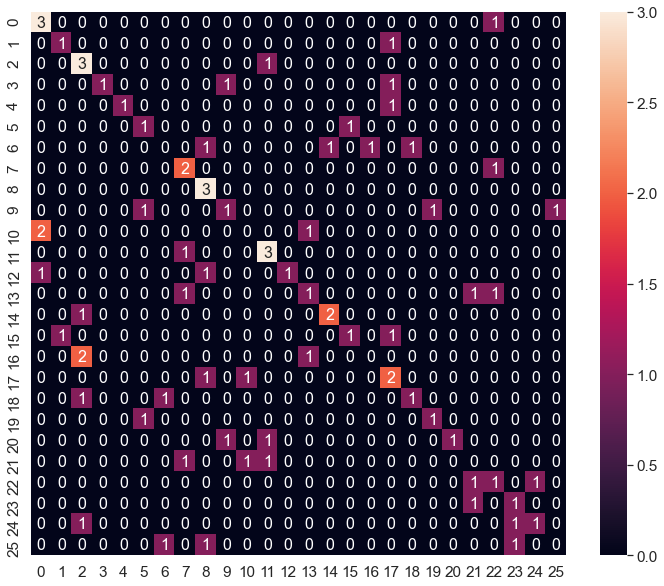


Classification report:
              precision    recall  f1-score   support

         0.0       0.50      0.75      0.60         4
         1.0       0.50      0.50      0.50         2
         2.0       0.38      0.75      0.50         4
         3.0       1.00      0.33      0.50         3
         4.0       1.00      0.50      0.67         2
         5.0       0.33      0.50      0.40         2
         6.0       0.00      0.00      0.00         4
         7.0       0.40      0.67      0.50         3
         8.0       0.43      1.00      0.60         3
         9.0       0.33      0.25      0.29         4
        10.0       0.00      0.00      0.00         3
        11.0       0.50      0.75      0.60         4
        12.0       1.00      0.33      0.50         3
        13.0       0.33      0.25      0.29         4
        14.0       0.67      0.67      0.67         3
        15.0       0.50      0.33      0.40         3
        16.0       0.00      0.00      0.00         3
   

In [16]:
# Base-DT-DS1
x_train = train_data_1[ :, :-1]
y_train = train_data_1[ :, -1]

base_t.fit(x_train, y_train)

x_test = labeled_test_data_1[ :, :-1]
y_test = labeled_test_data_1[ :, -1]

prediction = base_t.predict(x_test)
print([(entry, data_1[prediction[entry]]) for entry in range(prediction.size)])
print([(entry, data_1[y_test[entry]]) for entry in range(y_test.size)])
print((y_test != prediction).sum())


# write classification report
clsf_report = pd.DataFrame(classification_report(y_test, prediction, output_dict=True)).transpose()
clsf_report.to_csv('Base-DT-DS1.csv', index= True)

# write the predictions
with open('Base-DT-DS1.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for entry in range(prediction.size):
        writer.writerow([entry, int(prediction[entry])])
        
# get confusion matrix
labels = list(data_1.keys())
array = confusion_matrix(y_test, prediction, labels)
# append confusion matrix
with open("Base-DT-DS1.csv", "a") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(array)
    

#Plot confusion matrix: evaluates the quality of the output of the classifier
print("\n" + "Confusion matrix:")
df_cm = pd.DataFrame(array, range(26), range(26))
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
           
# show precision, recall, f1-score
print("\n" + "Classification report:")
report = classification_report(y_test, prediction)
print(report)
        


[(0, 'xi'), (1, 'pi'), (2, 'pi'), (3, 'delta'), (4, 'xi'), (5, 'alpha'), (6, 'alpha'), (7, 'alpha'), (8, 'mu'), (9, 'xi'), (10, 'xi'), (11, 'alpha'), (12, 'sigma'), (13, 'xi'), (14, 'alpha'), (15, 'sigma'), (16, 'xi'), (17, 'gamma'), (18, 'omega'), (19, 'alpha'), (20, 'lambda'), (21, 'alpha'), (22, 'gamma'), (23, 'omega'), (24, 'gamma'), (25, 'mu'), (26, 'alpha'), (27, 'alpha'), (28, 'mu'), (29, 'mu'), (30, 'xi'), (31, 'mu'), (32, 'mu'), (33, 'xi'), (34, 'beta'), (35, 'alpha'), (36, 'xi'), (37, 'xi'), (38, 'alpha'), (39, 'alpha'), (40, 'alpha'), (41, 'omega'), (42, 'beta'), (43, 'delta'), (44, 'xi'), (45, 'beta'), (46, 'alpha'), (47, 'alpha'), (48, 'delta'), (49, 'alpha'), (50, 'delta'), (51, 'gamma'), (52, 'delta'), (53, 'gamma'), (54, 'pi'), (55, 'alpha'), (56, 'mu'), (57, 'delta'), (58, 'beta'), (59, 'alpha'), (60, 'alpha'), (61, 'xi'), (62, 'pi'), (63, 'pi'), (64, 'xi'), (65, 'pi'), (66, 'alpha'), (67, 'xi'), (68, 'pi'), (69, 'beta'), (70, 'alpha'), (71, 'alpha'), (72, 'alpha'), (7

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


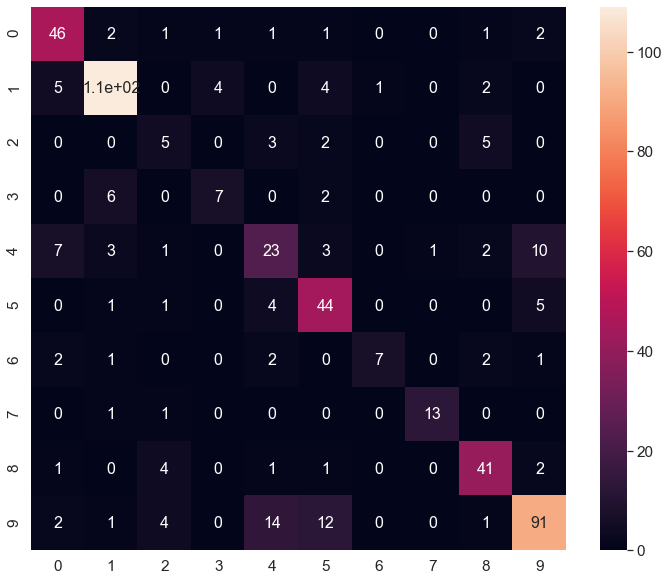


Classification report:
              precision    recall  f1-score   support

         0.0       0.73      0.84      0.78        55
         1.0       0.88      0.87      0.88       125
         2.0       0.29      0.33      0.31        15
         3.0       0.58      0.47      0.52        15
         4.0       0.48      0.46      0.47        50
         5.0       0.64      0.80      0.71        55
         6.0       0.88      0.47      0.61        15
         7.0       0.93      0.87      0.90        15
         8.0       0.76      0.82      0.79        50
         9.0       0.82      0.73      0.77       125

    accuracy                           0.74       520
   macro avg       0.70      0.66      0.67       520
weighted avg       0.75      0.74      0.74       520



In [17]:
# Base-DT-DS2
x_train = train_data_2[ :, :-1]
y_train = train_data_2[ :, -1]

base_t.fit(x_train, y_train)

x_test = labeled_test_data_2[ :, :-1]
y_test = labeled_test_data_2[ :, -1]

prediction = base_t.predict(x_test)
print([(entry, data_2[prediction[entry]]) for entry in range(prediction.size)])
print([(entry, data_2[y_test[entry]]) for entry in range(y_test.size)])
prediction = base_t.predict(x_test)
print((y_test != prediction).sum())


# write classification report
clsf_report = pd.DataFrame(classification_report(y_test, prediction, output_dict=True)).transpose()
clsf_report.to_csv('Base-DT-DS2.csv', index= True)

# write the predictions
with open('Base-DT-DS2.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for entry in range(prediction.size):
        writer.writerow([entry, int(prediction[entry])])
        
# get confusion matrix
labels = list(data_2.keys())
array = confusion_matrix(y_test, prediction, labels)
# append confusion matrix
with open("Base-DT-DS2.csv", "a") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(array)
    

#Plot confusion matrix: evaluates the quality of the output of the classifier
print("\n" + "Confusion matrix:")
df_cm = pd.DataFrame(array, range(10), range(10))
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
           
# show precision, recall, f1-score, etc
print("\n" + "Classification report:")
report = classification_report(y_test, prediction)
print(report)


# Brute Force Tree Optimization
- Trains new tree with different h-parameter to determine best performance
    - Loops through a variety of parameters, tracking the best case of predictions misses (best)
- Findings
    - Entropy as a split criterion is the best h-parameter
    - No max depth for the tree is the best h-parameter
    - Balanced class weights is the best h-parameter
    - Min Samples Split works best at very small numbers
        - testing with range down to 1/100000
    - Min Impurity Decrease works best at very small numbers
        - testing with range down to 1/100000

Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-100
Min Impurity Decrease:1e-100
Class Weights: Balanced
135
Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-100
Min Impurity Decrease:1e-101
Class Weights: Balanced
133
Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-100
Min Impurity Decrease:1e-105
Class Weights: Balanced
132
Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-101
Min Impurity Decrease:1e-100
Class Weights: Balanced
131
Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-101
Min Impurity Decrease:1e-102
Class Weights: Balanced
130
Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-102
Min Impurity Decrease:1e-106
Class Weights: Balanced
129
Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-108
Min Impurity Decrease:1e-108
Class Weights: Balanced
128
Tuned Model Mistakes:  39 out of 80

Confusion matrix:


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


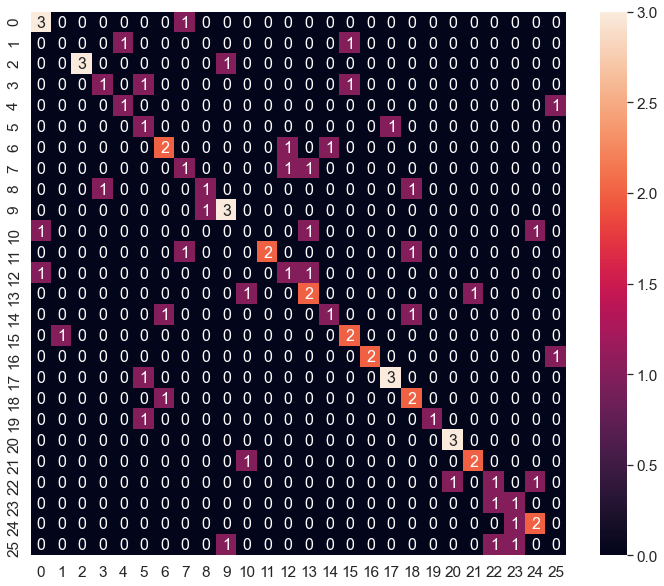


Classification report:
              precision    recall  f1-score   support

         0.0       0.60      0.75      0.67         4
         1.0       0.00      0.00      0.00         2
         2.0       1.00      0.75      0.86         4
         3.0       0.50      0.33      0.40         3
         4.0       0.50      0.50      0.50         2
         5.0       0.25      0.50      0.33         2
         6.0       0.50      0.50      0.50         4
         7.0       0.33      0.33      0.33         3
         8.0       0.50      0.33      0.40         3
         9.0       0.60      0.75      0.67         4
        10.0       0.00      0.00      0.00         3
        11.0       1.00      0.50      0.67         4
        12.0       0.33      0.33      0.33         3
        13.0       0.40      0.50      0.44         4
        14.0       0.50      0.33      0.40         3
        15.0       0.50      0.67      0.57         3
        16.0       1.00      0.67      0.80         3
   

In [18]:
# Tree Optimization DS1
x_train = train_data_1[ :, :-1]
y_train = train_data_1[ :, -1]

x_val = val_data_1[ :, :-1]
y_val = val_data_1[ :, -1]

x_test = labeled_test_data_1[ :, :-1]
y_test = labeled_test_data_1[ :, -1]

best = 239

def tree_score(sample, impurity):
    best_tree = tree.DecisionTreeClassifier(criterion="entropy", # Entropy is the best split criterion
                                       max_depth=None, # No max depth is best h-parameter
                                       min_samples_split=sample, # Small numbers here for best predictions
                                       min_impurity_decrease=impurity, # Small numbers here for best predictions
                                       class_weight="balanced") # Balanced class weights is the best h-paramter
    best_tree.fit(x_train, y_train)
    pred = best_tree.predict(x_val)
    return (y_val != pred).sum()

tuned_samples = 0
tuned_impurities = 0

for samples in [1/(10**x) for x in range(100, 110, 1)]: # Min Number of Samples
    for impurities in [1/(10**y) for y in range(100, 110, 1)]: # Min Impurity 
        # Decrease
            missed = tree_score(samples, impurities)
            if missed < best:
                print(f'Splitting Criterion: Entropy\n'
                      f'Max Depth: None\n'
                      f'Min # Samples: {samples}\n'
                      f'Min Impurity Decrease:{impurities}\n'
                      f'Class Weights: Balanced')
                tuned_samples = samples
                tuned_impurities = impurities
                best = missed
                print(missed)
            
tuned = tree.DecisionTreeClassifier(criterion="entropy", # Entropy is the best split criterion
                                       max_depth=None, # No max depth is best h-parameter
                                       min_samples_split=tuned_samples, # Small numbers here for best predictions
                                       min_impurity_decrease=tuned_impurities, # Small numbers here for best predictions
                                       class_weight="balanced")

prediction = tuned.fit(x_train, y_train).predict(x_test)
print('Tuned Model Mistakes: ', (y_test != prediction).sum(), 'out of 80')



# write classification report
clsf_report = pd.DataFrame(classification_report(y_test, prediction, output_dict=True)).transpose()
clsf_report.to_csv('Best-DT-DS1.csv', index= True)

# write the predictions
with open('Best-DT-DS1.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for entry in range(prediction.size):
        writer.writerow([entry, int(prediction[entry])])
        
# get confusion matrix
labels = list(data_1.keys())
array = confusion_matrix(y_test, prediction, labels)
# append confusion matrix
with open("Best-DT-DS1.csv", "a") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(array)
    

#Plot confusion matrix: evaluates the quality of the output of the classifier
print("\n" + "Confusion matrix:")
df_cm = pd.DataFrame(array, range(26), range(26))
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
           
# show precision, recall, f1-score
print("\n" + "Classification report:")
report = classification_report(y_test, prediction)
print(report)




Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-100
Min Impurity Decrease:1e-100
Class Weights: Balanced
358
Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-101
Min Impurity Decrease:1e-107
Class Weights: Balanced
354
Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-107
Min Impurity Decrease:1e-102
Class Weights: Balanced
352
Tuned Model Mistakes:  118 out of 520

Confusion matrix:


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


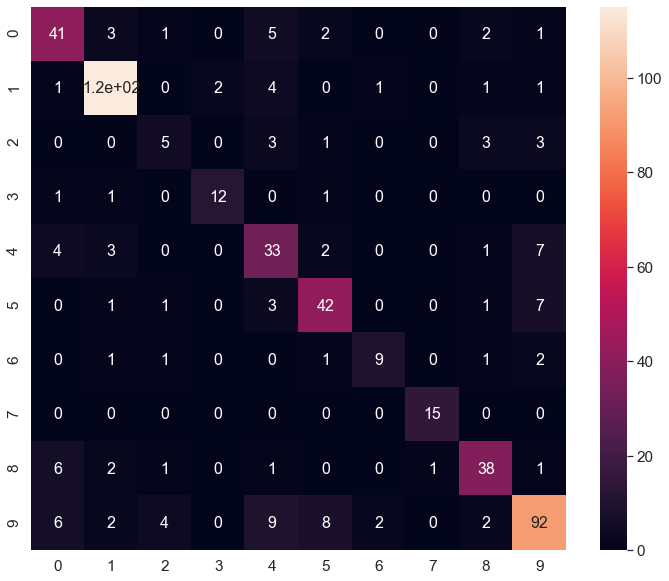


Classification report:
              precision    recall  f1-score   support

         0.0       0.69      0.75      0.72        55
         1.0       0.90      0.92      0.91       125
         2.0       0.38      0.33      0.36        15
         3.0       0.86      0.80      0.83        15
         4.0       0.57      0.66      0.61        50
         5.0       0.74      0.76      0.75        55
         6.0       0.75      0.60      0.67        15
         7.0       0.94      1.00      0.97        15
         8.0       0.78      0.76      0.77        50
         9.0       0.81      0.74      0.77       125

    accuracy                           0.77       520
   macro avg       0.74      0.73      0.73       520
weighted avg       0.78      0.77      0.77       520



In [19]:
# Tree Optimization DS2
x_train = train_data_2[ :, :-1]
y_train = train_data_2[ :, -1]

x_val = val_data_2[ :, :-1]
y_val = val_data_2[ :, -1]

x_test = labeled_test_data_2[ :, :-1]
y_test = labeled_test_data_2[ :, -1]

best = 1560

tuned_samples = 0
tuned_impurities = 0

for samples in [1/(10**x) for x in range(100, 110, 1)]: # Min Number of Samples
    for impurities in [1/(10**y) for y in range(100, 110, 1)]: # Min Impurity 
        # Decrease
            missed = tree_score(samples, impurities)
            if missed < best:
                print(f'Splitting Criterion: Entropy\n'
                      f'Max Depth: None\n'
                      f'Min # Samples: {samples}\n'
                      f'Min Impurity Decrease:{impurities}\n'
                      f'Class Weights: Balanced')
                tuned_samples = samples
                tuned_impurities = impurities
                best = missed
                print(missed)

tuned = tree.DecisionTreeClassifier(criterion="entropy", # Entropy is the best split criterion
                                       max_depth=None, # No max depth is best h-parameter
                                       min_samples_split=tuned_samples, # Small numbers here for best predictions
                                       min_impurity_decrease=tuned_impurities, # Small numbers here for best predictions
                                       class_weight="balanced")

prediction = tuned.fit(x_train, y_train).predict(x_test)
print('Tuned Model Mistakes: ', (y_test != prediction).sum(), 'out of 520')



# write classification report
clsf_report = pd.DataFrame(classification_report(y_test, prediction, output_dict=True)).transpose()
clsf_report.to_csv('Best-DT-DS2.csv', index= True)

# write the predictions
with open('Best-DT-DS2.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for entry in range(prediction.size):
        writer.writerow([entry, int(prediction[entry])])
        
# get confusion matrix
labels = list(data_2.keys())
array = confusion_matrix(y_test, prediction, labels)
# append confusion matrix
with open("Best-DT-DS2.csv", "a") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(array)
    

#Plot confusion matrix: evaluates the quality of the output of the classifier
print("\n" + "Confusion matrix:")
df_cm = pd.DataFrame(array, range(10), range(10))
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
           
# show precision, recall, f1-score, etc
print("\n" + "Classification report:")
report = classification_report(y_test, prediction)
print(report)




[(0, 'E'), (1, 'N'), (2, 'R'), (3, 'C'), (4, 'S'), (5, 'R'), (6, 'L'), (7, 'X'), (8, 'W'), (9, 'U'), (10, 'L'), (11, 'J'), (12, 'L'), (13, 'F'), (14, 'E'), (15, 'F'), (16, 'A'), (17, 'I'), (18, 'C'), (19, 'A'), (20, 'Q'), (21, 'A'), (22, 'J'), (23, 'R'), (24, 'J'), (25, 'B'), (26, 'V'), (27, 'I'), (28, 'Y'), (29, 'A'), (30, 'D'), (31, 'R'), (32, 'K'), (33, 'Q'), (34, 'K'), (35, 'R'), (36, 'Q'), (37, 'T'), (38, 'P'), (39, 'P'), (40, 'Q'), (41, 'L'), (42, 'N'), (43, 'B'), (44, 'N'), (45, 'H'), (46, 'K'), (47, 'O'), (48, 'Y'), (49, 'A'), (50, 'H'), (51, 'D'), (52, 'W'), (53, 'U'), (54, 'D'), (55, 'O'), (56, 'Z'), (57, 'J'), (58, 'P'), (59, 'O'), (60, 'M'), (61, 'C'), (62, 'L'), (63, 'H'), (64, 'R'), (65, 'G'), (66, 'G'), (67, 'U'), (68, 'M'), (69, 'N'), (70, 'Y'), (71, 'W'), (72, 'V'), (73, 'I'), (74, 'V'), (75, 'S'), (76, 'P'), (77, 'R'), (78, 'G'), (79, 'F')]
[(0, 'E'), (1, 'N'), (2, 'H'), (3, 'C'), (4, 'S'), (5, 'R'), (6, 'L'), (7, 'X'), (8, 'W'), (9, 'U'), (10, 'C'), (11, 'J'), (12, '

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


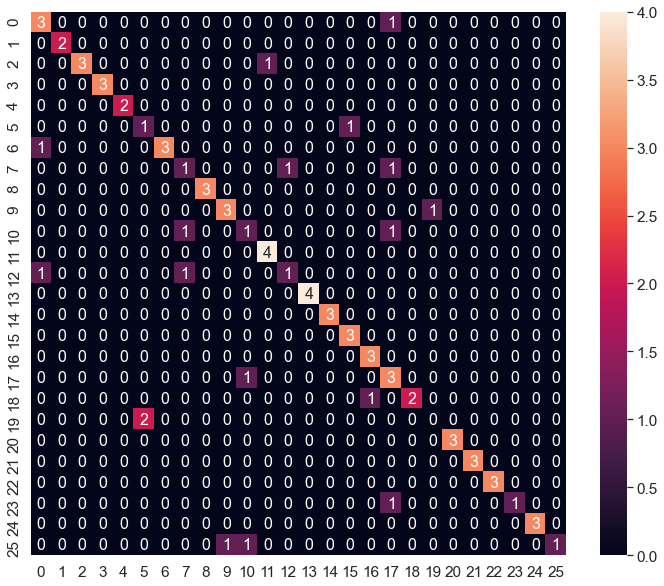


Classification report:
              precision    recall  f1-score   support

         0.0       0.60      0.75      0.67         4
         1.0       1.00      1.00      1.00         2
         2.0       1.00      0.75      0.86         4
         3.0       1.00      1.00      1.00         3
         4.0       1.00      1.00      1.00         2
         5.0       0.33      0.50      0.40         2
         6.0       1.00      0.75      0.86         4
         7.0       0.33      0.33      0.33         3
         8.0       1.00      1.00      1.00         3
         9.0       0.75      0.75      0.75         4
        10.0       0.33      0.33      0.33         3
        11.0       0.80      1.00      0.89         4
        12.0       0.50      0.33      0.40         3
        13.0       1.00      1.00      1.00         4
        14.0       1.00      1.00      1.00         3
        15.0       0.75      1.00      0.86         3
        16.0       0.75      1.00      0.86         3
   

In [20]:
#PER-DS1
x_train = train_data_1[ :, :-1]
y_train = train_data_1[ :, -1]

per.fit(x_train, y_train)

x_test = labeled_test_data_1[ :, :-1]
y_test = labeled_test_data_1[ :, -1]

prediction = per.predict(x_test)
print([(entry, data_1[prediction[entry]]) for entry in range(prediction.size)])
print([(entry, data_1[y_test[entry]]) for entry in range(y_test.size)])
print((y_test != prediction).sum())



# write classification report
clsf_report = pd.DataFrame(classification_report(y_test, prediction, output_dict=True)).transpose()
clsf_report.to_csv('PER-DS1.csv', index= True)

# write the predictions
with open('PER-DS1.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for entry in range(prediction.size):
        writer.writerow([entry, int(prediction[entry])])
        
# get confusion matrix
labels = list(data_1.keys())
array = confusion_matrix(y_test, prediction, labels)
# append confusion matrix
with open("PER-DS1.csv", "a") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(array)
    

#Plot confusion matrix: evaluates the quality of the output of the classifier
print("\n" + "Confusion matrix:")
df_cm = pd.DataFrame(array, range(26), range(26))
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
           
# show precision, recall, f1-score
print("\n" + "Classification report:")
report = classification_report(y_test, prediction)
print(report)




[(0, 'J'), (1, 'A'), (2, 'E'), (3, 'F'), (4, 'J'), (5, 'B'), (6, 'B'), (7, 'D'), (8, 'I'), (9, 'J'), (10, 'A'), (11, 'B'), (12, 'D'), (13, 'J'), (14, 'J'), (15, 'D'), (16, 'J'), (17, 'J'), (18, 'H'), (19, 'B'), (20, 'G'), (21, 'B'), (22, 'J'), (23, 'H'), (24, 'J'), (25, 'B'), (26, 'B'), (27, 'B'), (28, 'I'), (29, 'I'), (30, 'J'), (31, 'I'), (32, 'A'), (33, 'J'), (34, 'I'), (35, 'B'), (36, 'J'), (37, 'J'), (38, 'B'), (39, 'B'), (40, 'B'), (41, 'H'), (42, 'A'), (43, 'F'), (44, 'J'), (45, 'J'), (46, 'B'), (47, 'B'), (48, 'F'), (49, 'B'), (50, 'J'), (51, 'A'), (52, 'F'), (53, 'J'), (54, 'A'), (55, 'A'), (56, 'I'), (57, 'F'), (58, 'E'), (59, 'B'), (60, 'B'), (61, 'J'), (62, 'A'), (63, 'A'), (64, 'J'), (65, 'A'), (66, 'B'), (67, 'E'), (68, 'A'), (69, 'B'), (70, 'D'), (71, 'B'), (72, 'B'), (73, 'J'), (74, 'F'), (75, 'I'), (76, 'J'), (77, 'B'), (78, 'A'), (79, 'J'), (80, 'H'), (81, 'B'), (82, 'A'), (83, 'F'), (84, 'A'), (85, 'G'), (86, 'J'), (87, 'J'), (88, 'H'), (89, 'B'), (90, 'I'), (91, 'F'

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


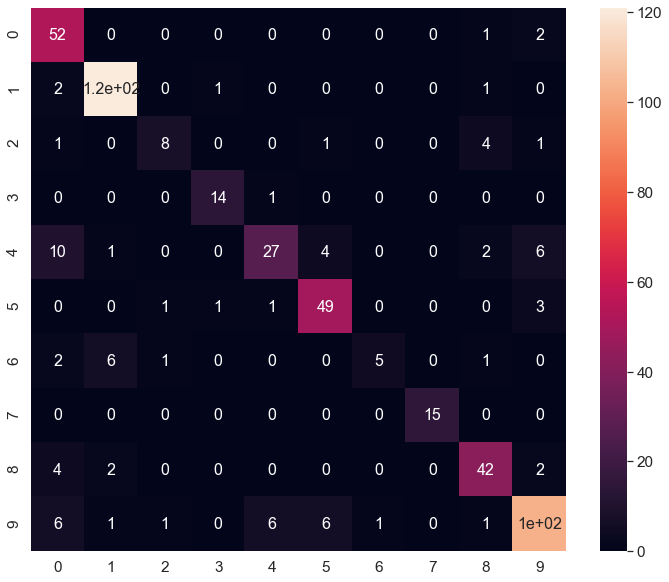


Classification report:
              precision    recall  f1-score   support

         0.0       0.68      0.95      0.79        55
         1.0       0.92      0.97      0.95       125
         2.0       0.73      0.53      0.62        15
         3.0       0.88      0.93      0.90        15
         4.0       0.77      0.54      0.64        50
         5.0       0.82      0.89      0.85        55
         6.0       0.83      0.33      0.48        15
         7.0       1.00      1.00      1.00        15
         8.0       0.81      0.84      0.82        50
         9.0       0.88      0.82      0.85       125

    accuracy                           0.84       520
   macro avg       0.83      0.78      0.79       520
weighted avg       0.84      0.84      0.83       520



In [21]:
#PER-DS2
x_train = train_data_2[ :, :-1]
y_train = train_data_2[ :, -1]

per.fit(x_train, y_train)

x_test = labeled_test_data_2[ :, :-1]
y_test = labeled_test_data_2[ :, -1]

prediction = per.predict(x_test)
print([(entry, data_1[prediction[entry]]) for entry in range(prediction.size)])
print([(entry, data_1[y_test[entry]]) for entry in range(y_test.size)])
print((y_test != prediction).sum())



# write classification report
clsf_report = pd.DataFrame(classification_report(y_test, prediction, output_dict=True)).transpose()
clsf_report.to_csv('PER-DS2.csv', index= True)

# write the predictions
with open('PER-DS2.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for entry in range(prediction.size):
        writer.writerow([entry, int(prediction[entry])])
        
# get confusion matrix
labels = list(data_2.keys())
array = confusion_matrix(y_test, prediction, labels)
# append confusion matrix
with open("PER-DS2.csv", "a") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(array)
    

#Plot confusion matrix: evaluates the quality of the output of the classifier
print("\n" + "Confusion matrix:")
df_cm = pd.DataFrame(array, range(10), range(10))
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
           
# show precision, recall, f1-score, etc
print("\n" + "Classification report:")
report = classification_report(y_test, prediction)
print(report)


        